In [1]:
!pip install nibabel
!pip install nilearn
!pip install pydicom
!pip install tensorboardX
!pip install tqdm

In [1]:
#General imports
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os

from subprocess import call
import sys
import xml.etree.ElementTree as ET

#Pytorch imports
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

#Local imports
from utils import Logger,load_old_model
from train import train_epoch
from validation import val_epoch
from nvnet import MiniNvNet, NvNet
from metrics import CombinedLoss, SoftDiceLoss
from dataset import BratsDataset, StanfordDataset, StanfordSmallDataset

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
#When there's 2 GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="1,0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

torch.cuda.empty_cache()
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')

# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
__pyTorch VERSION: 1.1.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7501
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
DATASET_GLOBAL_MEAN = 321.56370587244527
DATASET_GLOBAL_STDDEV = 517.4083720223107

DATASET_SAG_MEAN = 319.38926782103283
DATASET_SAG_STDDEV = 447.42789129337154

config = dict()
config["cuda_devices"] = None
# config["labels"] = (1, 2, 4)
config["labels"] = (1,) # change label to train
config["model_file"] = os.path.abspath("single_label_{}_dice.h5".format(config["labels"][0]))
config["initial_learning_rate"] = 1e-4
config["batch_size"] = 2
config["validation_batch_size"] = 2
config["image_shape"] = (128, 128, 128)
# config["image_shape"] = (160, 512, 512)
# config["image_shape"] = (160, 256, 256)
config["activation"] = "relu"
config["normalizaiton"] = "group_normalization"
config["mode"] = "trilinear"
config["n_labels"] = len(config["labels"])
#config["all_modalities"] = ["t1", "t1ce", "flair", "t2"]
config["all_modalities"] = ["bilat"]#["t1", "sag"]
config["training_modalities"] = config["all_modalities"]  # change this if you want to only use some of the modalities
config["nb_channels"] = len(config["training_modalities"])
config["input_shape"] = tuple([config["batch_size"]] + [config["nb_channels"]] + list(config["image_shape"]))
config["loss_k1_weight"] = 0.1
config["loss_k2_weight"] = 0.1
config["random_offset"] = False # Boolean. Augments the data by randomly move an axis during generating a data
config["random_flip"] = False  # Boolean. Augments the data by randomly flipping an axis during generating a data
# config["permute"] = True  # data shape must be a cube. Augments the data by permuting in various directions
config["random_crop"] = False  # Boolean. Augments the data by randomly cropping in depth dimension
config["random_intensity_shift"] = False  # Boolean. Augments the data by randomly shifting and scaling pixel values
config["result_path"] = "./checkpoint_models/"
config["data_file"] = os.path.abspath("isensee_mixed_brats_data.h5")
# config["training_file"] = os.path.abspath("isensee_mixed_training_ids.pkl")
# config["validation_file"] = os.path.abspath("isensee_mixed_validation_ids.pkl")
# config["test_file"] = os.path.abspath("isensee_mixed_validation_ids.pkl")
config["training_dir"] = "data/preprocessed/sag/train"
config["validation_dir"] = "data/preprocessed/sag/val"
config["test_dir"] = "data/preprocessed/sag/test"
config["saved_model_file"] = None#"checkpoint_models/single_label_1_dice/best_model_file.pth" #None
config["overwrite"] = False  # If True, will create new files. If False, will use previously written files.
config["L2_norm"] = 1e-5
config["patience"] = 2
config["lr_decay"] = 0.7
config["epochs"] = 300
config["checkpoint"] = True  # Boolean. If True, will save the best model as checkpoint.
config["label_containing"] = True  # Boolean. If True, will generate label with overlapping.
config["VAE_enable"] = True  # Boolean. If True, will enable the VAE module.
#config["best_model_file"] = "checkpoint_models/v1/best_model_file_38.pth"
config["best_model_file"] = "checkpoint_models/v1/best_model_file_90.pth"

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    config["cuda_devices"] = True
else:
    device = torch.device('cpu')
    config["cuda_devices"] = None

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
#Load model
model = torch.load(config["best_model_file"], map_location=device)
model.eval()

NvNet(
  (in_conv0): DownSampling(
    (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (dropout): Dropout3d(p=0.2, inplace)
  )
  (en_block0): EncoderBlock(
    (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
    (actv1): ReLU(inplace)
    (actv2): ReLU(inplace)
    (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (en_down1): DownSampling(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
  )
  (en_block1_0): EncoderBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (actv1): ReLU(inplace)
    (actv2): ReLU(inplace)
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (conv2): Conv3d(64, 64, kernel_si

In [6]:
#Load input
test_data = 'data/preprocessed/sag/dicom_converted/1688915074_0/img.nii'
img = nib.load(test_data).get_data()
D, H, W = img.shape
print(img.shape)
height_downsample_factor = H//128
width_downsample_factor = W//128

(200, 256, 256)


In [15]:
final_output = np.zeros((D, 128, 128))
summed_output = np.zeros((D, 128, 128))

for i in range(D-128+1):
    inputs = img[np.newaxis, np.newaxis, i:i+128, ::height_downsample_factor, ::width_downsample_factor]
    inputs = torch.from_numpy(inputs)
    inputs = inputs.type(torch.FloatTensor)
    if config["cuda_devices"] is not None:
        inputs = inputs.cuda()
    with torch.no_grad():
        if config["VAE_enable"]:
            outputs, distr = model(inputs)
        else:
            outputs = model(inputs)   
    output_array = np.asarray(outputs.tolist())
    output_array = output_array[0,0,:,:,:]
    #print(i, i+127, output_array.max())
    summed_output[i:i+128, :, :] += output_array

for i in range(D):
    if i < D / 2:
        n = min(128, i + 1)
    else:
        n = min(128, D - i)
    final_output[i, :, :] = summed_output[i, :, :] / n
    
#Upsample width and height dimension
final_output = final_output.repeat(height_downsample_factor, axis=1).repeat(width_downsample_factor, axis=2)

#Convert to binary mask
final_seg = np.where(final_output > 0.5, 1, 0)

0 0.6880975365638733
1 0.7004303932189941
2 0.7029936909675598
3 0.7000474333763123
4 0.6806145906448364
5 0.6610764861106873
6 0.6398860812187195
7 0.6359903216362
8 0.6338632702827454
9 0.6395993828773499
10 0.6325904130935669
11 0.6212514638900757
12 0.5890971422195435
13 0.556854784488678
14 0.5210187435150146
15 0.5052343010902405
16 0.49107110500335693
17 0.48949888348579407
18 0.4754631519317627
19 0.46083372831344604
20 0.42692333459854126
21 0.40174657106399536
22 0.37899935245513916
23 0.3827908933162689
24 0.3923281729221344
25 0.4202929139137268
26 0.4390621781349182
27 0.46140363812446594
28 0.4592910706996918
29 0.4578064978122711
30 0.4474809765815735
31 0.4666145145893097
32 0.48905283212661743
33 0.5235777497291565
34 0.5282466411590576
35 0.5318339467048645
36 0.5061246752738953
37 0.47330039739608765
38 0.45729169249534607
39 0.461943119764328
40 0.4465509057044983
41 0.39478421211242676
42 0.3372282087802887
43 0.2848871946334839
44 0.27628448605537415
45 0.27375966

In [43]:
print(final_seg.shape)
print(final_seg.max())
print(final_output.max())
print(summed_output[5:].max())
#final_output[:90, :, :] = np.zeros((90, H, W))

(200, 256, 256)
1
0.4756956715946612
21.882000893354416


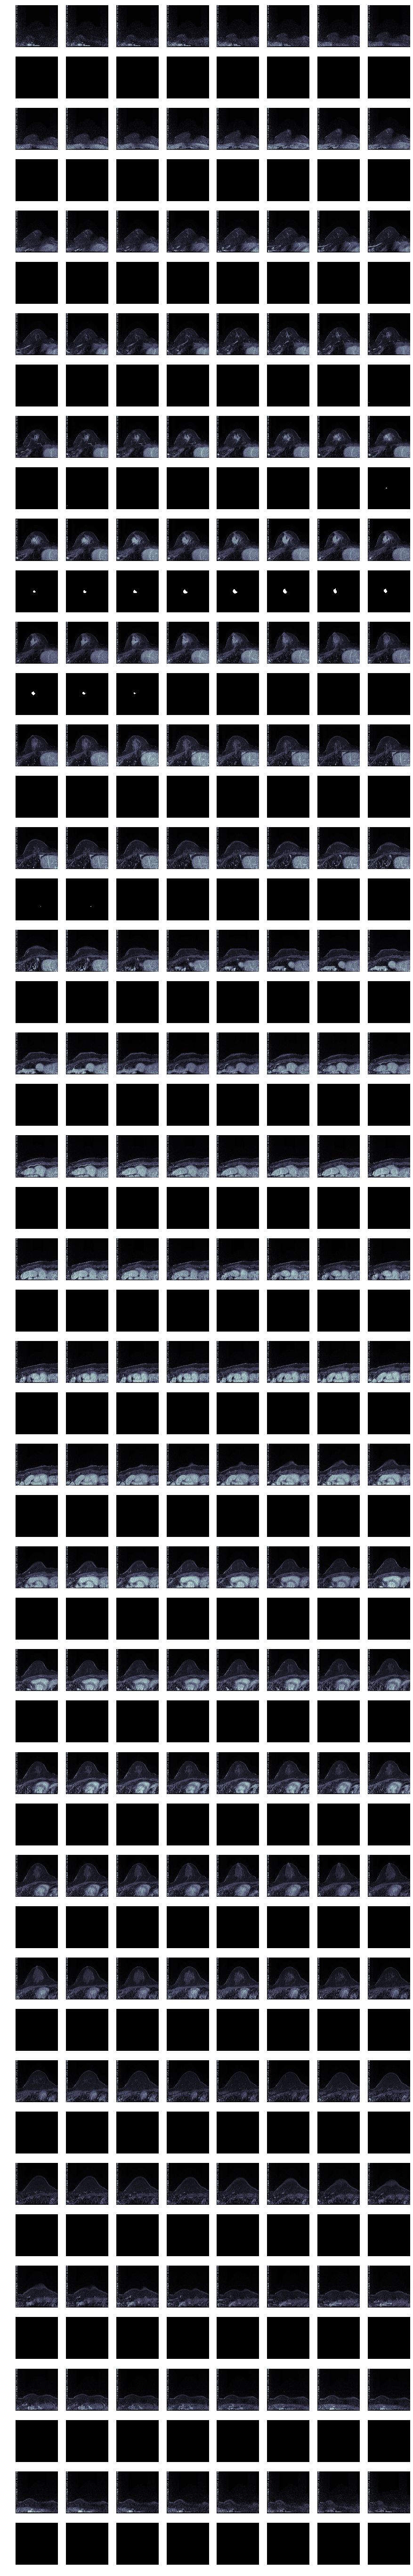

In [44]:
#Plot
num_cols = 8
num_rows = D // num_cols

for i in range(num_cols):
    for j in range(num_rows):
        plt.subplot(num_rows * 2, num_cols, (2*j) * num_cols + i + 1)
        plt.imshow(img[i + j * num_cols, :, :] * DATASET_SAG_STDDEV + DATASET_SAG_MEAN, cmap=plt.cm.bone)
        plt.axis('off')
        plt.subplot(num_rows * 2, num_cols, (2*j+1) * num_cols + i + 1)
        plt.imshow(final_seg[i + j * num_cols, :, :], cmap=plt.cm.bone)
        plt.axis('off')
plt.gcf().set_size_inches(15, 100)
plt.show()

In [36]:
#Save prediction
final_seg_img = nib.Nifti1Image(final_output, affine=np.eye(4))
output_dir = 'data/preprocessed/sag/dicom_converted/1575473977_4'
output_filename = "prediction.nii"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
nib.save(final_seg_img, os.path.join(output_dir, output_filename))